In [50]:
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns

In [ ]:
# Downloading the MNIST dataset through the tensorflow library (just to get it simpler and replicate in your directory)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")

Training data shape: (60000, 28, 28)
Training labels shape: (60000,)


In [ ]:
# Normalizing the x_train and x_test -> Stable gradient descend and prevent Vanishing gradient values in range(0,1)
x_train = x_train / 255.0
x_test = x_test / 255.0


In [ ]:
# test the shape of x_test
x_test.shape

(10000, 28, 28)

In [7]:
np.max(x_train) # just check if the maxmium value is 1 (needs to be 1)

np.float64(1.0)

In [ ]:
# organizing our x_train to be in the shape that we need to do forward propagation
x_train = x_train.reshape(x_train.shape[0], -1)  # The -1 automatically calculates 28*28 = 784

x_train = x_train.T

print(x_train.shape)

(784, 60000)


In [ ]:
# same for x_test
x_test = x_test.reshape(x_test.shape[0], -1)
x_test = x_test.T
x_test.shape

(784, 10000)

In [ ]:
# manual one hot encoding - old -> 7 --- new ->(0,0,0,0,0,0,0,1,0,0)
def one_hot_encode(Y):
    num_classes = Y.max() + 1
    num_examples = Y.size

    one_hot_Y = np.zeros((num_classes, num_examples)) # create an big array with all the inputs that we need (makes senses in my mind)
    one_hot_Y[Y, np.arange(num_examples)] = 1 # position and in the number of our example

    return one_hot_Y

In [ ]:
# applying one hot encode to our y_train and y_test
y_train = one_hot_encode(y_train)

y_test = one_hot_encode(y_test)

In [ ]:
# initializing paramters

def init_params():
    # initialize weights with small random values to break symmetry
    W1 = np.random.rand(15, 784) - 0.5
    b1 = np.random.rand(15, 1) - 0.5
    W2 = np.random.rand(15, 15) - 0.5
    b2 = np.random.rand(15, 1) - 0.5
    W3 = np.random.rand(10, 15) - 0.5
    b3 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2, W3, b3

In [ ]:
# Creating our functions and derivatives

def ReLU(Z):
    return np.maximum(Z,0)

def softmax(Z):
    A = np.exp(Z - np.max(Z)) / np.sum(np.exp(Z - np.max(Z)), axis=0)
    return A

def ReLU_deriv(Z):
    return Z > 0
    
# we don't need the sigmoid derivative due a relation between the cross entropy and the derivative od a sigmoid function

In [14]:
def foward_prop(W1,b1,W2,b2,W3,b3, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)

    Z2 = W2.dot(A1) + b2
    A2 = ReLU(Z2)

    Z3 = W3.dot(A2) + b3
    A3 = softmax(Z3)

    return Z1,A1,Z2,A2,Z3,A3

In [15]:
def backward_prop(Z1, A1, Z2, A2, A3, W2, W3, X, Y):
    m = Y.shape[1]

    # Gradients for the output layer
    dZ3 = A3 - Y
    dW3 = (1 / m) * dZ3.dot(A2.T)
    db3 = (1 / m) * np.sum(dZ3, axis=1, keepdims=True)

    # Gradients for the second hidden layer
    dZ2 = W3.T.dot(dZ3) * ReLU_deriv(Z2)
    dW2 = (1 / m) * dZ2.dot(A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)

    # Gradients for the first hidden layer
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = (1 / m) * dZ1.dot(X.T)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)

    return dW1, db1, dW2, db2, dW3, db3

In [16]:
def update_params(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    W3 = W3 - alpha * dW3
    b3 = b3 - alpha * db3
    return W1, b1, W2, b2, W3, b3

In [17]:
def descend_gradient(X, Y, alpha, iterations) : 
    W1, b1, W2, b2, W3, b3  = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2, Z3, A3 = foward_prop(W1, b1, W2, b2, W3, b3, X)
        dW1, db1, dW2, db2, dW3, db3 = backward_prop(Z1, A1, Z2, A2, A3, W2, W3, X, Y)
        W1, b1, W2, b2, W3, b3 = update_params(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, alpha)

        if i % 10 == 0:
            predictions = np.argmax(A3, axis=0)
            true_labels = np.argmax(Y, axis=0)
            accuracy = np.sum(predictions == true_labels) / Y.shape[1]
            print(f"Iteration: {i}, Accuracy: {accuracy:.4f}")

    return W1, b1, W2, b2, W3, b3

In [27]:
def mini_batch_gradient_descent(X, Y, alpha, iterations, batch_size):
    W1, b1, W2, b2, W3, b3 = init_params()
    m = X.shape[1] # Number of total examples
    
    for i in range(iterations):
        # Shuffle the data at the start of each epoch
        # This creates a random permutation of indices
        permutation = np.random.permutation(m)
        shuffled_X = X[:, permutation]
        shuffled_Y = Y[:, permutation]
        
        # Iterate over mini-batches
        for j in range(0, m, batch_size):
            X_batch = shuffled_X[:, j:j+batch_size]
            Y_batch = shuffled_Y[:, j:j+batch_size]

            # Forward and backward propagation on the batch
            Z1, A1, Z2, A2, Z3, A3 = foward_prop(W1, b1, W2, b2, W3, b3, X_batch)
            dW1, db1, dW2, db2, dW3, db3 = backward_prop(Z1, A1, Z2, A2, A3, W2, W3, X_batch, Y_batch)
            W1, b1, W2, b2, W3, b3 = update_params(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, alpha)
        
        if i % 10 == 0:
            # You can calculate accuracy on the full training set or a validation set
            _, _, _, _, _, A3_full = foward_prop(W1, b1, W2, b2, W3, b3, X)
            predictions = np.argmax(A3_full, axis=0)
            true_labels = np.argmax(Y, axis=0)
            accuracy = np.sum(predictions == true_labels) / Y.shape[1]
            print(f"Iteration: {i}, Accuracy: {accuracy:.4f}")
            
    return W1, b1, W2, b2, W3, b3

In [40]:
W1, b1, W2, b2, W3, b3 = mini_batch_gradient_descent(x_train, y_train, 0.1, 100,32)

Iteration: 0, Accuracy: 0.9020
Iteration: 10, Accuracy: 0.9517
Iteration: 20, Accuracy: 0.9603
Iteration: 30, Accuracy: 0.9672
Iteration: 40, Accuracy: 0.9678
Iteration: 50, Accuracy: 0.9666
Iteration: 60, Accuracy: 0.9728
Iteration: 70, Accuracy: 0.9749
Iteration: 80, Accuracy: 0.9747
Iteration: 90, Accuracy: 0.9751


In [41]:
_, _, _, _, _, A3 = foward_prop(W1, b1, W2, b2, W3, b3, x_test)

In [42]:
predictions = np.argmax(A3, axis = 0)

y_test_values = np.argmax(y_test, axis = 0)

print("First 10 predictions:" , predictions[0:10])
print("First 10 true values:" , y_test_values[0:10])


First 10 predictions: [7 2 1 0 4 1 4 9 6 9]
First 10 true values: [7 2 1 0 4 1 4 9 5 9]


In [46]:
correct_predictions = predictions == y_test_values # compare with true labels

accuracy = np.sum(correct_predictions) / y_test_values.size # compute accuracy

print(f"Test Set Accuracy: {accuracy:.4f}")                

Test Set Accuracy: 0.9497


In [47]:
misclassified_indices = np.where(predictions != y_test_values)[0]

misclassified_index = misclassified_indices[0]

# Get the predicted and true labels for this specific example
predicted_label = predictions[misclassified_index]
true_label = y_test_values[misclassified_index]

In [48]:
misclassified_image_flat = x_test[:, misclassified_index + 1]

# Reshape the flat array back to a 28x28 grid
misclassified_image_2d = misclassified_image_flat.reshape(28, 28)

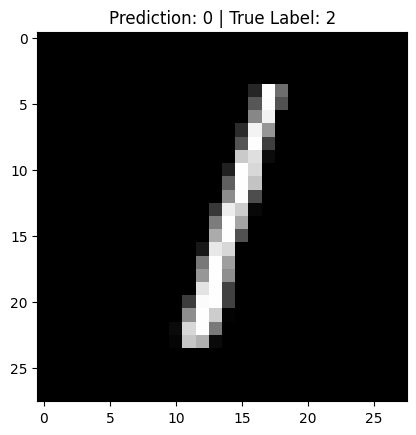

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(misclassified_image_2d, cmap='gray')

plt.title(f"Prediction: {predicted_label} | True Label: {true_label}")
plt.show()

In [37]:
def get_confusion_matrix(predictions, true_labels):
    # Determine the number of classes (0-9)
    num_classes = np.max(true_labels) + 1
    
    # Initialize the matrix with zeros
    conf_matrix = np.zeros((num_classes, num_classes), dtype=int)
    
    # Populate the matrix by counting occurrences
    for i in range(true_labels.size):
        true_class = true_labels[i]
        predicted_class = predictions[i]
        conf_matrix[true_class, predicted_class] += 1
        
    return conf_matrix



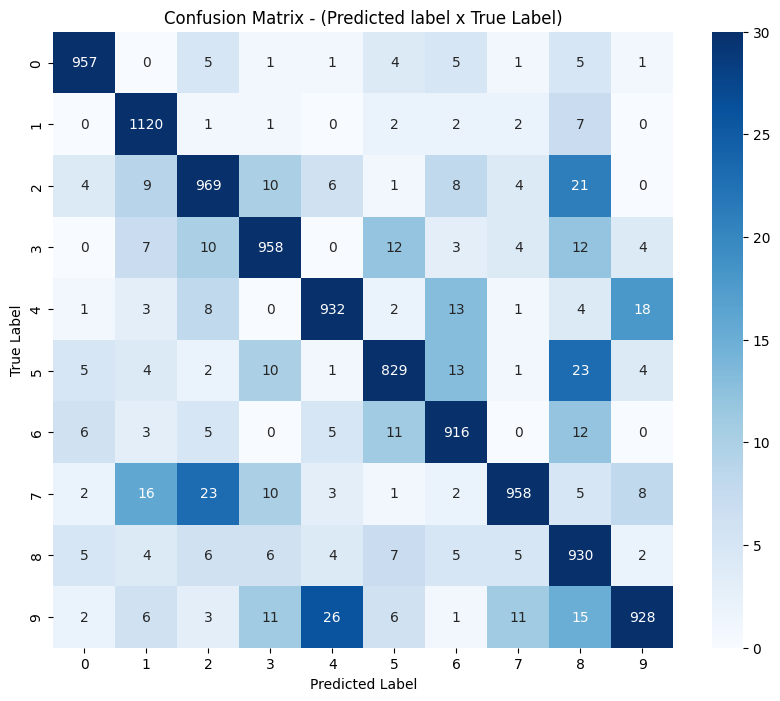

In [53]:
y_test_values = np.argmax(y_test, axis=0)
confusion_matrix = get_confusion_matrix(predictions, y_test_values)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', vmin=0, vmax=30)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - (Predicted label x True Label)')
plt.show()

In [ ]:
"""

Gridsearch, don't run every time (takes 2h to run =[ )

learning_rates = [0.1, 0.01, 0.001]

batch_sizes = [32, 64, 128]

best_accuracy = 0
best_params = {}

for lr in learning_rates:
    for bs in batch_sizes:
        print(f"Training with learning rate: {lr} and batch size: {bs}")

        # Re-initialize parameters for each new training run
        W1, b1, W2, b2, W3, b3 = init_params()

        # Train the model with the current combination of hyperparameters
        W1, b1, W2, b2, W3, b3 = mini_batch_gradient_descent(x_train, y_train, lr, 500, bs)

        # Evaluate the trained model on the test set
        _, _, _, _, _, A3 = foward_prop(W1, b1, W2, b2, W3, b3, x_test)
        
        predictions = np.argmax(A3, axis=0)
        Y_test_labels = np.argmax(y_test, axis=0)
        accuracy = np.mean(predictions == Y_test_labels)

        # Compare the current accuracy with the best one found so far
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {'learning_rate': lr, 'batch_size': bs}
            
print("\n--- Grid Search Results ---")
print(f"Best Accuracy: {best_accuracy:.4f}")
print(f"Best Hyperparameters: {best_params}")
"""

Training with learning rate: 0.1 and batch size: 32
Iteration: 0, Accuracy: 0.9024
Iteration: 10, Accuracy: 0.9498
Iteration: 20, Accuracy: 0.9601
Iteration: 30, Accuracy: 0.9595
Iteration: 40, Accuracy: 0.9675
Iteration: 50, Accuracy: 0.9684
Iteration: 60, Accuracy: 0.9641
Iteration: 70, Accuracy: 0.9681
Iteration: 80, Accuracy: 0.9720
Iteration: 90, Accuracy: 0.9683
Iteration: 100, Accuracy: 0.9739
Iteration: 110, Accuracy: 0.9777
Iteration: 120, Accuracy: 0.9780
Iteration: 130, Accuracy: 0.9709
Iteration: 140, Accuracy: 0.9774
Iteration: 150, Accuracy: 0.9771
Iteration: 160, Accuracy: 0.9712
Iteration: 170, Accuracy: 0.9778
Iteration: 180, Accuracy: 0.9790
Iteration: 190, Accuracy: 0.9801
Iteration: 200, Accuracy: 0.9816
Iteration: 210, Accuracy: 0.9802
Iteration: 220, Accuracy: 0.9788
Iteration: 230, Accuracy: 0.9808
Iteration: 240, Accuracy: 0.9778
Iteration: 250, Accuracy: 0.9794
Iteration: 260, Accuracy: 0.9771
Iteration: 270, Accuracy: 0.9793
Iteration: 280, Accuracy: 0.9800
It